There are two axes of neural network uncertainty that can be modeled: 
- uncertainty in the data, called aleatoric uncertainty. This could be for example sensor noise or motion noise, resulting in uncertainty which cannot be reduced even if more data were to be collected. 
- uncertainty in the prediction, called epistemic uncertainty. It can be explained away given enough data, and is often referred to as model uncertainty.

In this notebook we will train models which can predict both types of uncertainty. We will see that model exhibits
- increased aleatoric uncertainty on object boundaries and for objects far from the camera
- increased epistemic uncertainty for semantically and visually challenging pixels.

However modeling only one of them comes at a cost. Out-of-distribution examples, which can be identified with epistemic uncertainty, cannot be identified with aleatoric uncertainty alone and vice versa.
We will see a failure case of the regression model when the model fails due to increased epistemic uncertainty, but not aleatoric uncertainty. Thus we will combine both of the uncertainties to leverage their strength. 

In [1]:
import sys
sys.path.append('..')

In [2]:
import tensorflow as tf
import configs.demo as config
from utils import notebook_select_gpu
notebook_select_gpu(3)

In [3]:
from wrap import get_datasets
ds_train, ds_test, ds_ood = get_datasets()

### Base model

We demonstrate how capsa can be used as a large-scale risk and uncertainty benchmarking framework for existing methods in the community. To that end, we train a U-Net style model on the task of monocular end-to-end depth
estimation. First, we initialize a base model and visualize its prediction.

In [4]:
from models import unet
user_model = unet(compile=True)

Visualize prediction of an untrained model

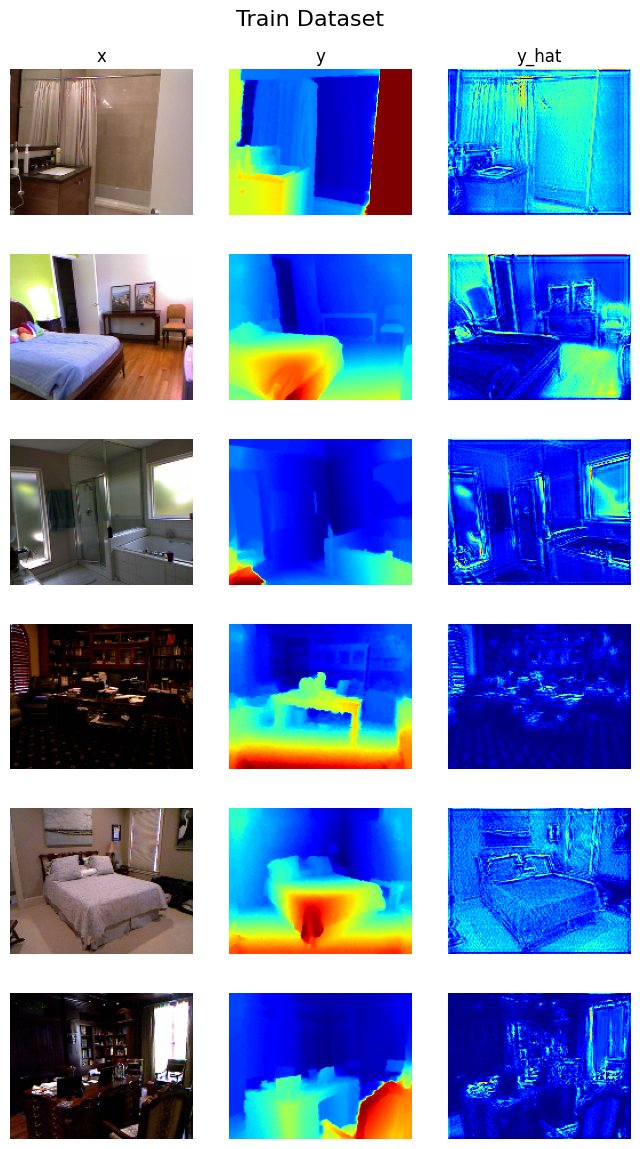

In [5]:
from wrap import vis_depth_map
vis_depth_map(user_model, ds_train, plot_uncertainty=False)

##### Train

In [6]:
# history = user_model.fit(ds_train, epochs=config.EP,
#     validation_data=ds_test,
# )

##### Load trained model

2022-10-11 16:14:07.639803: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open /home/iaroslavelistratov/results/base/20220926-170005-new_callback/checkpoints/0.002790vloss_43010iter.tf: FAILED_PRECONDITION: /home/iaroslavelistratov/results/base/20220926-170005-new_callback/checkpoints/0.002790vloss_43010iter.tf; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


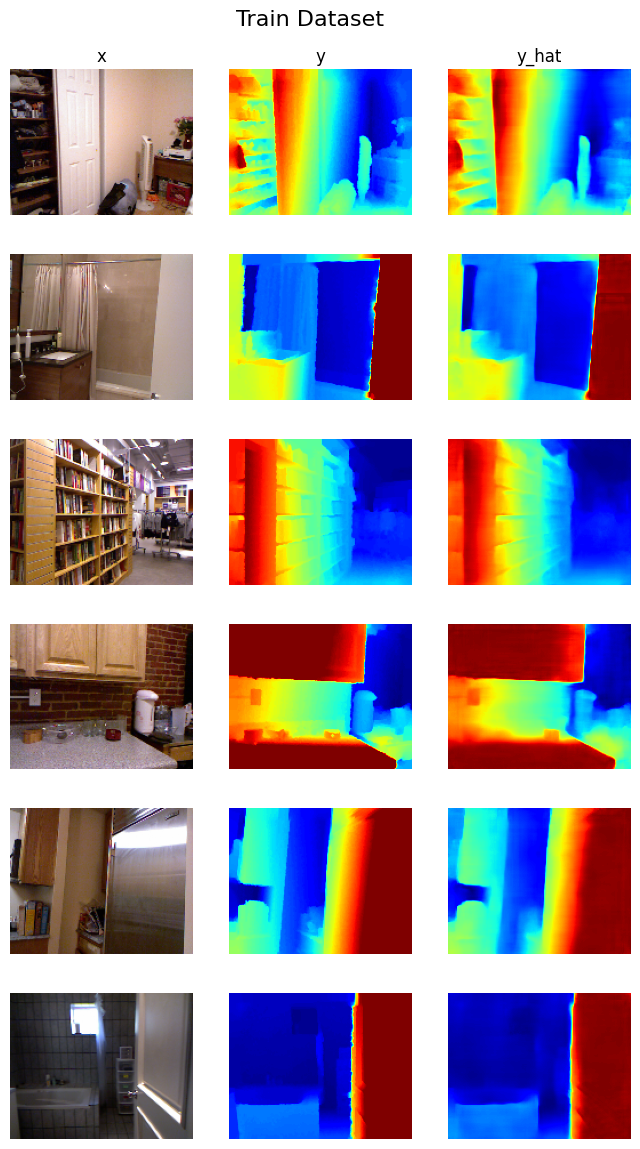

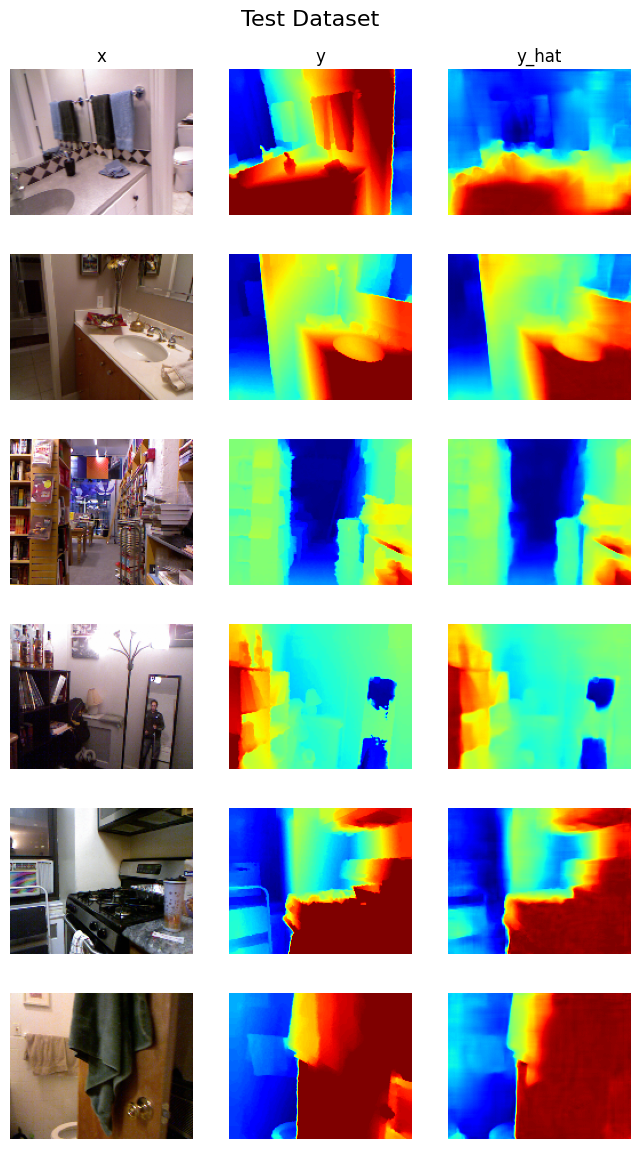

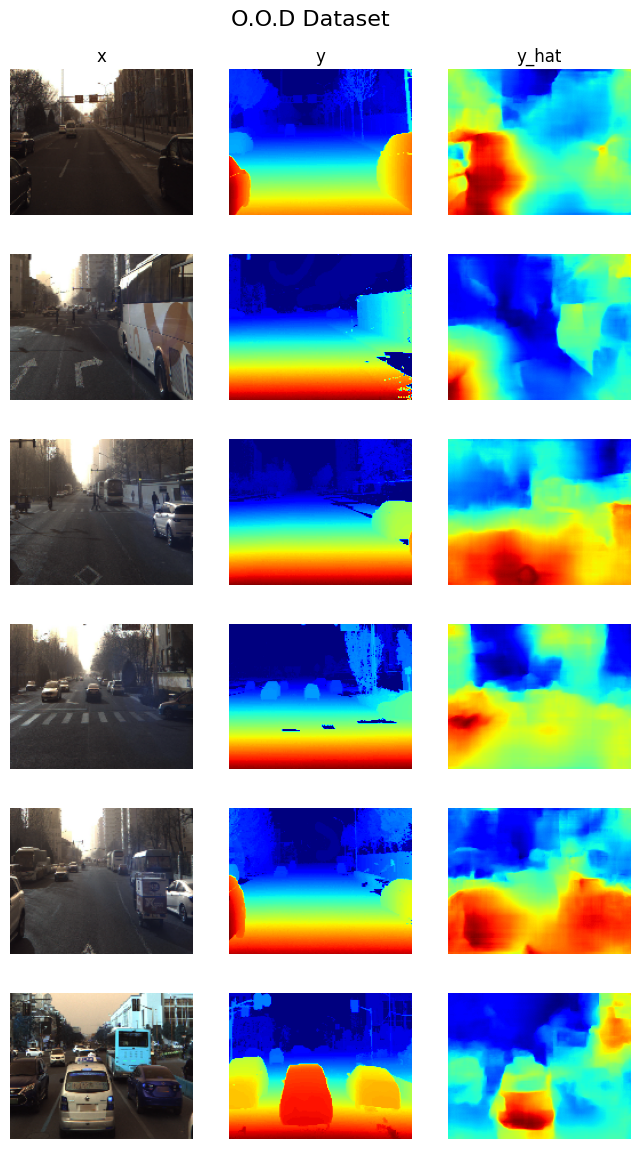

In [7]:
from wrap import load_model
trained_user_model = load_model(config.BASE_PATH, ds_train)
vis_depth_map(trained_user_model, ds_train, ds_test, ds_ood, plot_uncertainty=False)

## Capsa

Existing algorithms to achieve risk-awareness of NNs are complex and ad-hoc. Specifically, these methods require significant engineering changes, are often developed only for particular settings, and are not easily
composable.

We present Capsa -- a model agnostic framework for risk estimation. Which allows for seamless and efficient integration of the uncertainty estimates to the existing models in a couple
lines of code.

Wrappers transform a model into a risk-aware variant. They are given an arbitrary neural network and, while preserving the structure and function of the network, add and modify the relevant components of the model in order to be a drop-in replacement while being able to estimate the risk metric.

### Aleatoric Wrapper
Allows to capture uncertainty in the data. This could be for example sensor noise or motion noise, resulting in uncertainty which cannot be reduced even if more data were to be collected.

To leverage the functionality provided by Capsa, user could simply wrap their model with one of our wrappers.

Detailed documentation could be found [here](https://themisai.io/capsa/api_documentation/index.html).

In [8]:
from wrap import AleatoricWrapper
user_model = unet()
aleatoric_model = AleatoricWrapper(user_model)

##### Train

In [9]:
# history = aleatoric_model.fit(ds_train, epochs=config.EP,
#     validation_data=ds_test,
# )

##### Load trained model

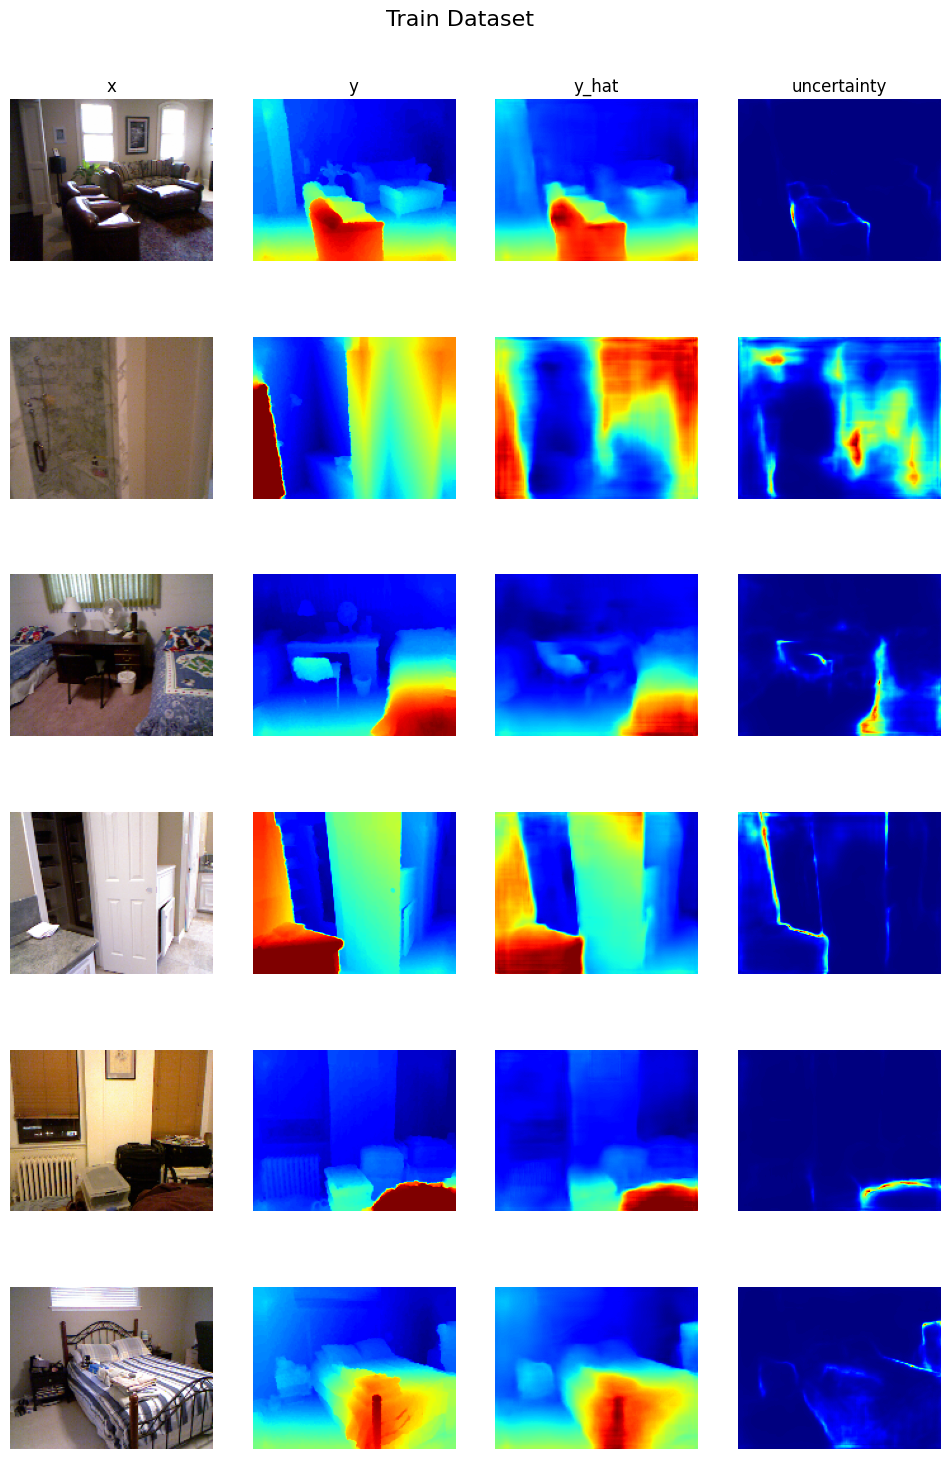

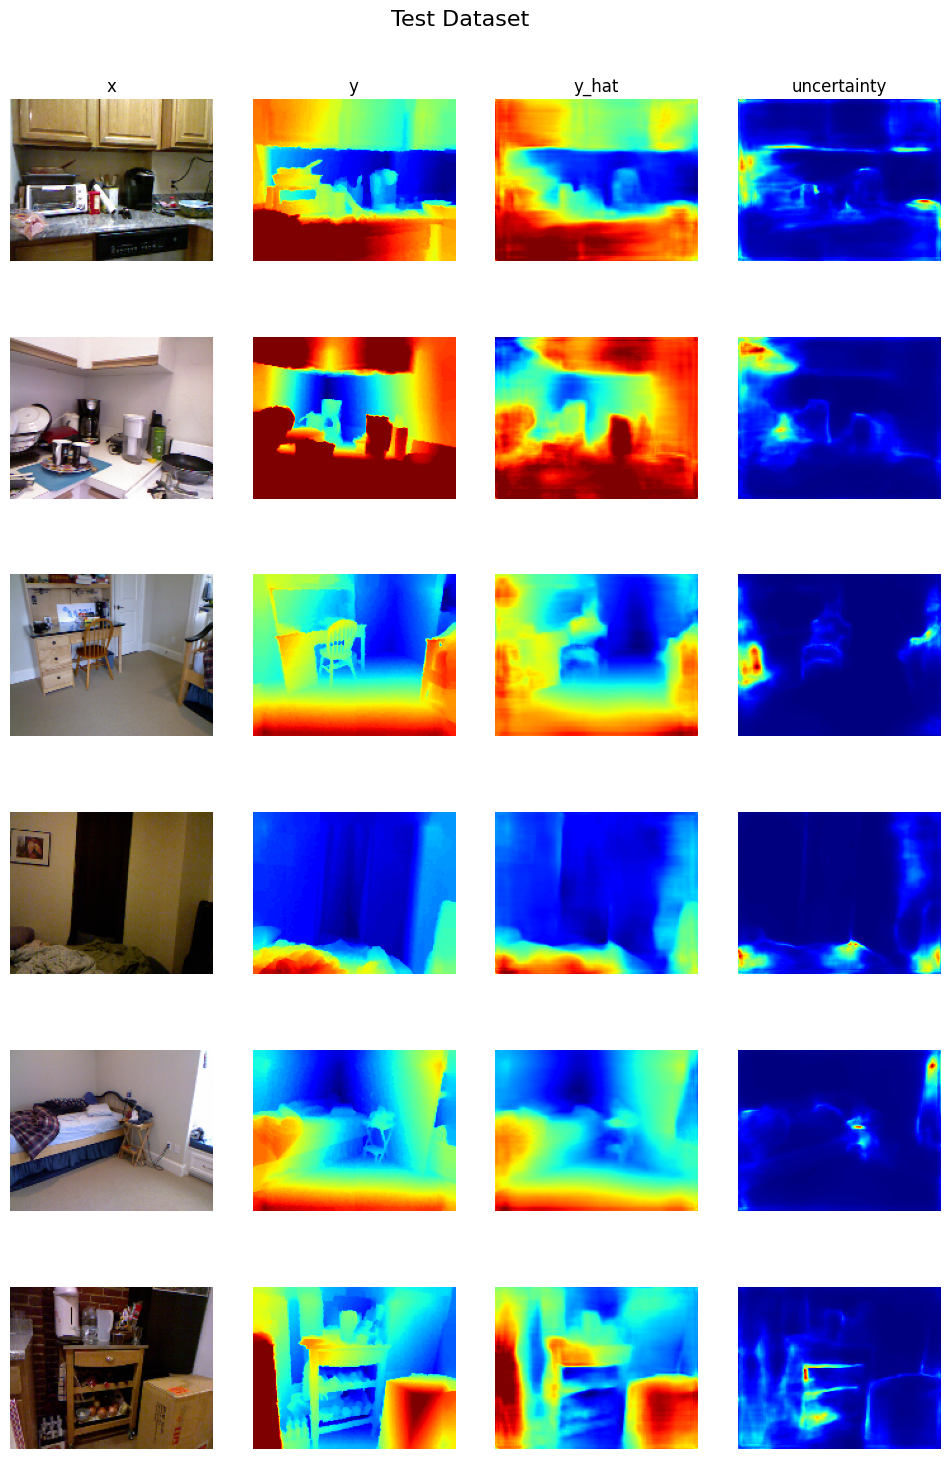

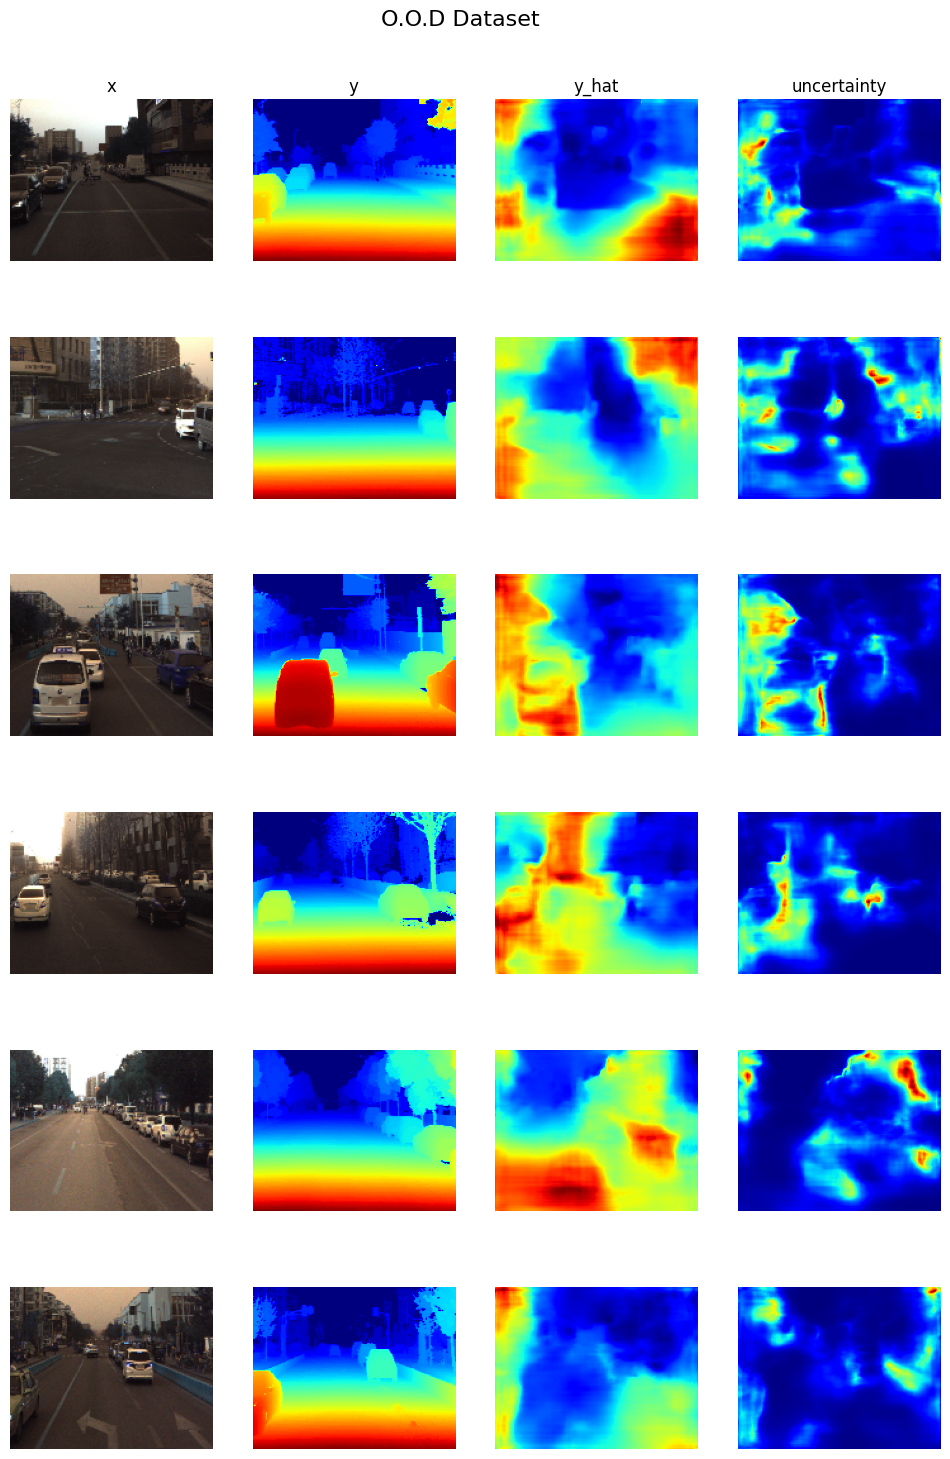

In [10]:
trained_aleatoric = load_model(config.ALEATORIC_PATH, ds_train)
vis_depth_map(trained_aleatoric, ds_train, ds_test, ds_ood)

### Epistemic Wrapper

Allows to capture uncertainty in the prediction. It can be explained away given enough data, and is often referred to as model uncertainty.

In [11]:
from wrap import EpistemicWrapper
user_model = unet()
epistemic_model = EpistemicWrapper(user_model)

##### Train

In [12]:
# history = epistemic_model.fit(ds_train, epochs=config.EP,
#     validation_data=ds_test,
# )

##### Load trained model

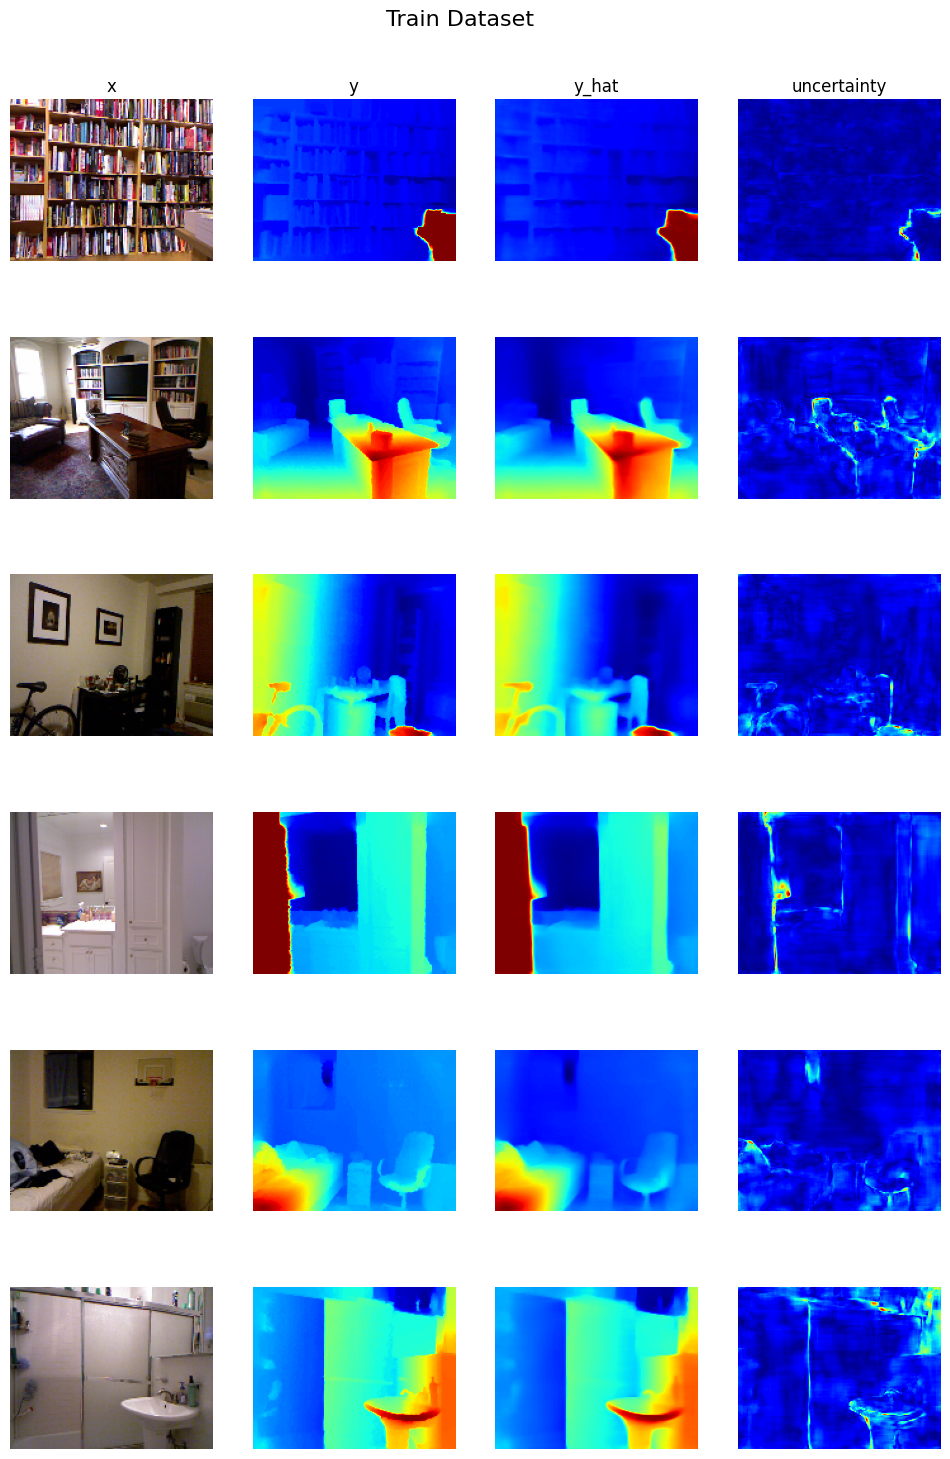

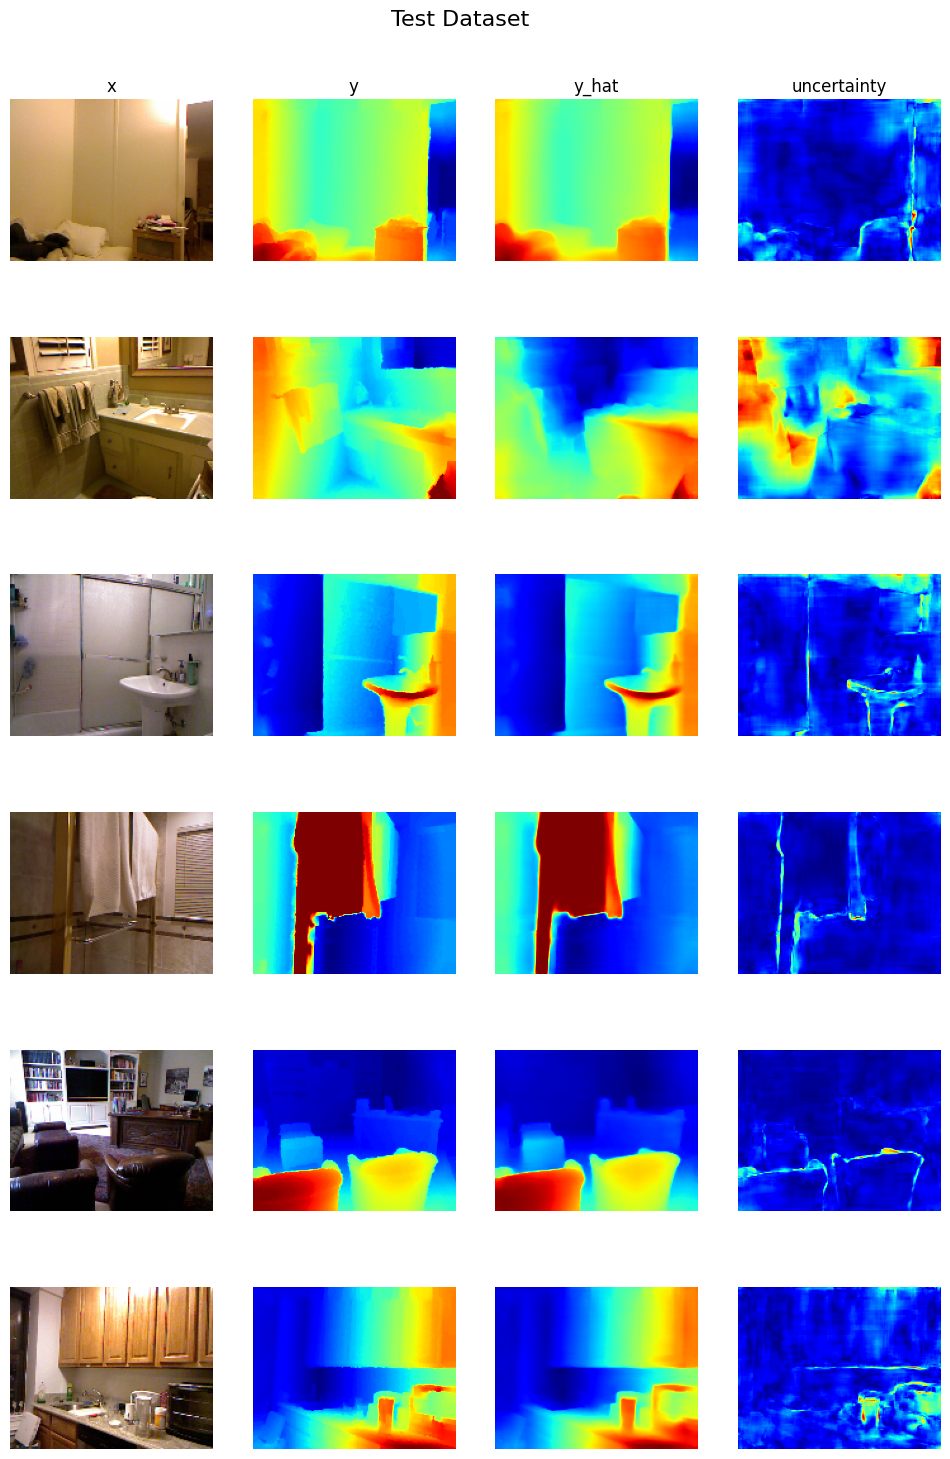

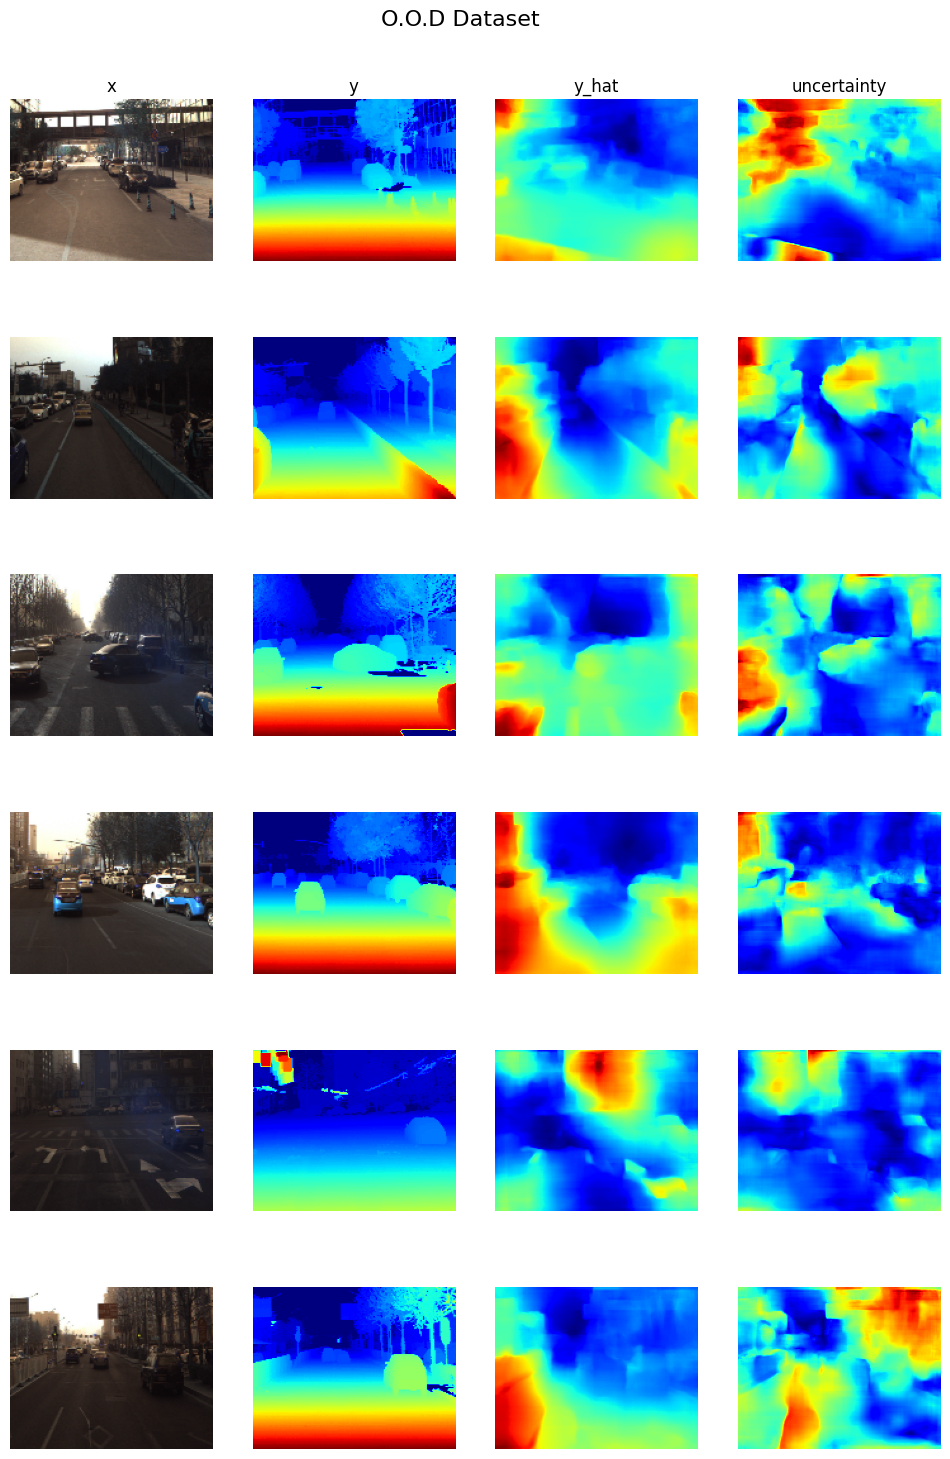

In [13]:
trained_epistemic = load_model(config.EPISTEMIC_PATH, ds_train)
vis_depth_map(trained_epistemic, ds_train, ds_test, ds_ood)

##### Generate OOD plots

Another application of the “uncertainty estimation” functionality provided by capsa is anomaly
detection. The core idea behind this approach is that a model’s epistemic uncertainty on out-ofdistribution (OOD) data is naturally higher than the same model’s epistemic uncertainty on indistribution (ID) data. Thus, given a risk aware model we visualize density histograms of per image
uncertainty estimates provided by a model on both ID (unseen test-set for NYU Depth V2 dataset)
and OOD data (ApolloScapes). At this point, OOD detection is possible by a simple
thresholding.

It is critical for a model to recognize that it is presented with an unreasonable input (e.g., OOD);
in the real world this could be used for an autonomous vehicle yielding control to a human if the
perception system detects that it is presented with such an input image as it is expected that model’s
performance on this datapoint will be poor. However, as we are able
to detect such a distribution shift, model can pass this information downstream to avoid potentially
disastrous prediction before it actually happens.

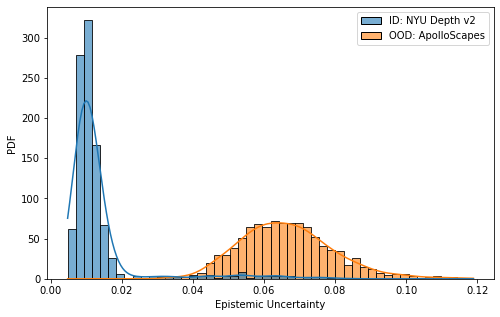

In [ ]:
from utils import gen_ood_comparison
gen_ood_comparison(ds_test, ds_ood, trained_epistemic)